## Import module

In [1]:
import os
import sys
import math
from collections import defaultdict
import numpy as np
import pandas as pd
import glob
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, YearLocator,WeekdayLocator, MonthLocator, DayLocator, MONDAY, YEARLY
from matplotlib.ticker import MultipleLocator

## Plot function

In [2]:
def StandardPlot(ax, fontsize=12, grid=True, ticks=True, left=True, right=True, top=True, bottom=True):
    font_label = {'family': 'arial', 'size': 12}
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('arial') for label in labels]
    if grid == True:
        ax.xaxis.grid(linestyle='--', c='grey',
                      alpha=0.4, linewidth=0.2, zorder=0)
        ax.yaxis.grid(linestyle='--', c='grey',
                      alpha=0.4, linewidth=0.2, zorder=0)
    if ticks == True:
        ax.tick_params(axis='x', direction='out',
                       color='black', labelsize=fontsize, pad=3)
        ax.tick_params(axis='y', direction='out',
                       color='black', labelsize=fontsize, pad=3)
    ax.spines['left'].set_visible(left)
    ax.spines['right'].set_visible(right)
    ax.spines['top'].set_visible(top)
    ax.spines['bottom'].set_visible(bottom)
    return ax

def shannon_entropy(value_lst, base=math.e):
    adct = {}
    length = len(value_lst)
    for i in value_lst:
        adct[i] = adct.get(i, 0) + 1 / length
    H2 = []
    for x, y in adct.items():
        H2.append(y * math.log(y, base))
    return -sum(H2)

## GLM model predicts provincial outward exports

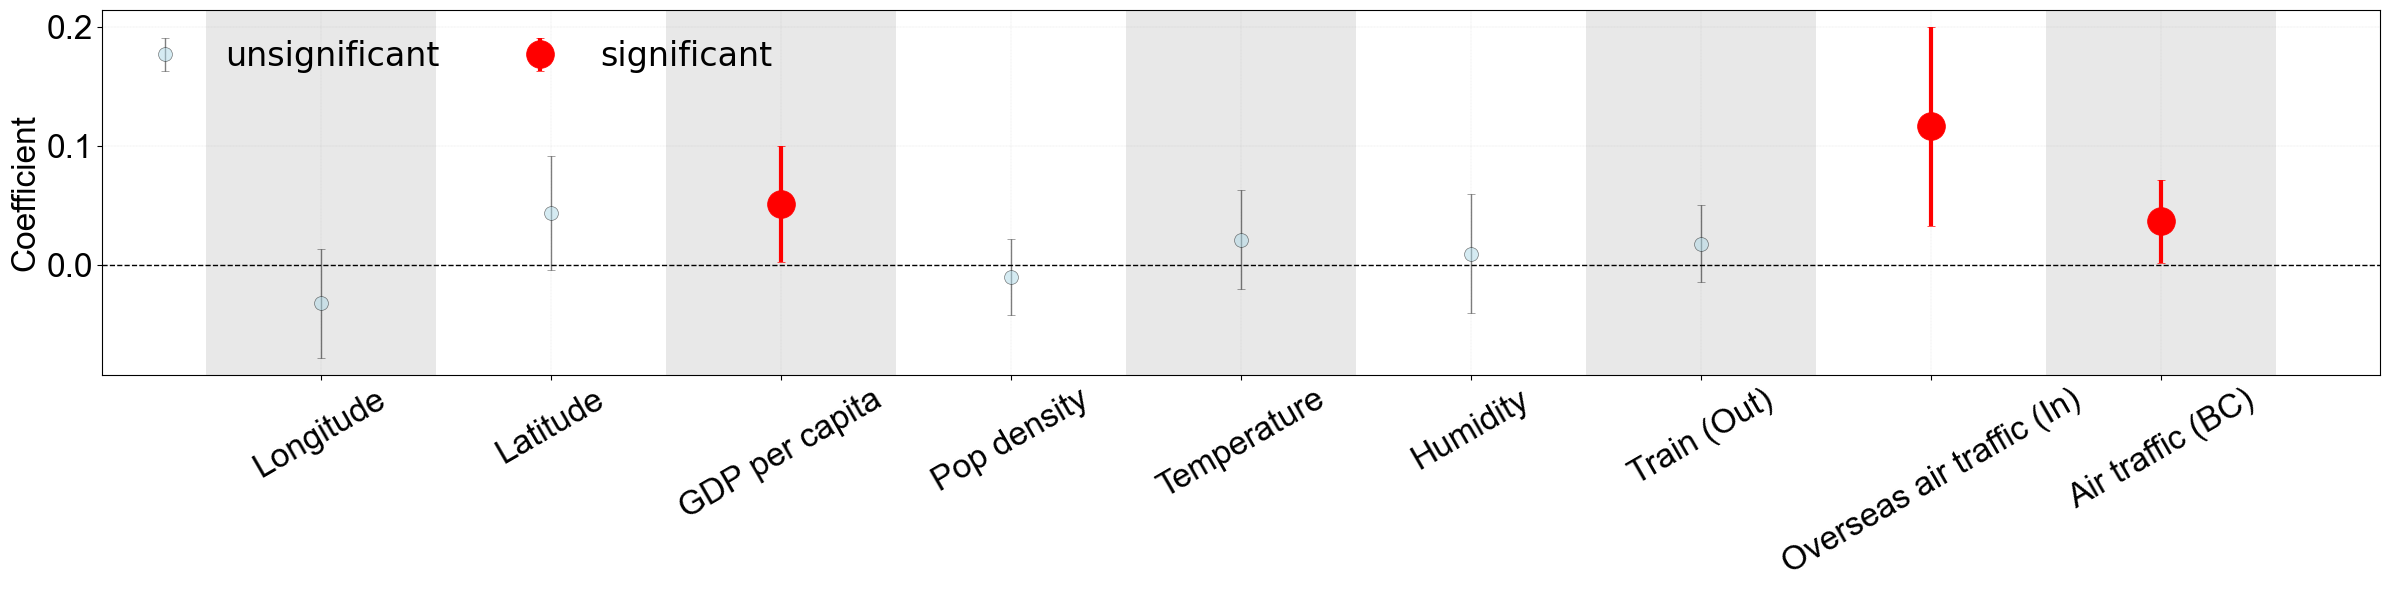

In [3]:
col_queue = ['Longitude','Latitude','GDP per capita','Pop density','Temperature','Humidity',
             'Train (Out)','Overseas air traffic (In)','Air traffic (BC)']
df = pd.read_csv('../results/glm/domestic_exports/model_result.csv',index_col=0)
df = df.reindex(col_queue)
df = df.reset_index(drop=False,names= ['factor']).dropna(subset='factor')
X_lst = df.factor.unique().tolist()
Y_lst = df['Coef.']
Y_err_lst= df['Std.Err.']*1.96
P_value_lst = df['P>|z|']
fontsize =24
plt.rcParams['pdf.fonttype'] = 42
fig, ax = plt.subplots(1,1, figsize=(24,6))
p_lst= []
for xi,yi,y_err_i,p_value_i in zip(X_lst,Y_lst,Y_err_lst,P_value_lst):
    if p_value_i<=0.05:
        ax.errorbar(xi,yi, y_err_i, 
                    fmt='o',mec='red',mew = 0.5,ms=20,c = 'red',
                    capthick=0.5, capsize=3,ecolor='red',elinewidth=3,alpha = 1,label = 'significant')
    else:
        ax.errorbar(xi,yi, y_err_i, 
                    fmt='o',mec='k',mew = 0.5,ms=10,c = 'lightblue',
                    capthick=0.5, capsize=3,ecolor='k',elinewidth=1,alpha = 0.5,label = 'unsignificant')            
for i in range(0,len(X_lst),2):
    ax.axvspan(i-0.5, i+0.5, facecolor='lightgrey',alpha = 0.5)
ax = StandardPlot(ax,fontsize=fontsize)
ax.axhline(y=0,linewidth = 1,color = 'k',linestyle='--') 
ax.set_ylabel('Coefficient',{'family': 'arial', 'size': 24})
ax.tick_params(axis='x', direction='out',color='black', labelsize=fontsize, pad=3,rotation = 30)
ax.tick_params(axis='y', direction='out',color='black', labelsize=24, pad=3)
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[0],handles[2]],[labels[0],labels[-2]],ncols = 2,
          loc='upper left',fontsize = fontsize,frameon= False)
plt.tight_layout()

## Temporal dynamics of the number of imported strains and the proportion of imported strains in each province

0.4884393063583815


Text(0, 0.5, 'Proportion')

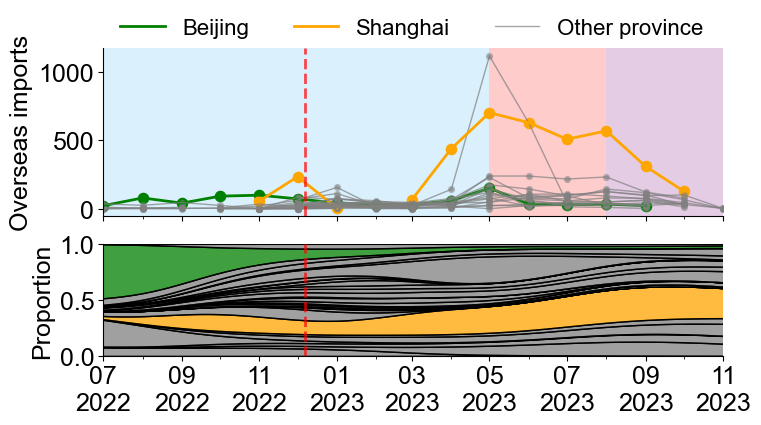

In [4]:
dominant_Omicron_sublineages = [ 'BA.5','BF.7', 'DY','XBB','EG.5','HK']
prov_lst = ['Anhui', 'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong', 'Guangxi', 'Guizhou', 
            'Hainan', 'Hebei', 'Heilongjiang', 'Henan', 'Hubei', 'Hunan', 'Jiangsu', 'Jiangxi', 'Jilin', 
            'Liaoning', 'Neimenggu', 'Ningxia', 'Qinghai', 'Shaanxi', 'Shandong', 'Shanghai', 'Shanxi', 'Sichuan', 
            'Tianjin', 'Xinjiang', 'Xizang', 'Yunnan', 'Zhejiang']
color_dct = {i:'grey' for i in prov_lst}
color_dct['Beijing']='green'
color_dct['Shanghai'] = 'orange'
color_dct2 = {'Beijing':'indianred','Shanghai':'royalblue','Others':'grey'}
date_range = (202207,202311)
fontsize=18
plt.rcParams['pdf.fonttype'] = 42
fig, ax = plt.subplots(2,1,figsize = (8,4),sharex='all',gridspec_kw={'height_ratios': [0.6,0.4]})
ax_array = ax.flatten()
ax1 = ax_array[0]
ax2 = ax_array[1]
df_net_lst = []
for lineage in dominant_Omicron_sublineages:
    df_net = pd.read_csv('../results/mutnet/Overseas_%s_network.csv' % lineage)
    df_net_lst.append(df_net)
df = pd.concat(df_net_lst)
df['t_year_month'] = ['%s-%s' % (i.split('-')[0],i.split('-')[1]) for i in df['t_date']]
df = df[(df['t_year_month'] >='2022-07') & (df['t_year_month']<='2023-11')]
trans_dct = defaultdict(dict)
for x, y in df['weight'].groupby([df['t_year_month'], df['t_prov']]):
    trans_dct[x[0]][x[1]] = len(y)
df_trans = pd.DataFrame(trans_dct)
date_lst =  [datetime.datetime.strptime(str(i), '%Y-%m') for i in df_trans.columns]  
for prov in df_trans.index:
    v_lst = df_trans.loc[prov].tolist()
    if prov=='Beijing':
        ax1.plot(date_lst,v_lst,color = color_dct['Beijing'],linewidth = 2,alpha = 1,zorder = 2,label ='Beijing')
        ax1.scatter(date_lst,v_lst,ec = color_dct['Beijing'],c = color_dct['Beijing'],alpha =1,s=40,linewidths = 2)
        
    elif prov=='Shanghai':
        ax1.plot(date_lst,v_lst,color = color_dct['Shanghai'],linewidth =2,alpha = 1,zorder = 2,label ='Shanghai')
        ax1.scatter(date_lst,v_lst,ec = color_dct['Shanghai'],c = color_dct['Shanghai'],alpha = 1,s=40,linewidths = 2)
    else:
        ax1.plot(date_lst,v_lst,color = 'grey',linewidth =1,alpha = 0.7,zorder = 2,label= 'Other province')
        ax1.scatter(date_lst,v_lst,ec = 'grey',c = 'grey',alpha = 0.5,s = 10,linewidths = 2)    
df_trans['key'] = df_trans.index.tolist()
df_plot = pd.melt(df_trans, ['key']).rename({'key':'province','variable':'date'},axis = 1)
df_plot['province2'] = [i if i in color_dct2 else 'Others' for i in df_plot['province']]
df_plot['province'] = [str(i) for i in df_plot['province']]
df_plot['rank'] = [prov_lst.index(i) for i in df_plot['province']]
df_plot = df_plot.sort_values(by='rank', ascending=True)
df_plot = df_plot.fillna(0)
# Beijing imported strains accounting for 49% of its total during July 2022 and November 2022
print(df_plot.query('province=="Beijing" & date>= "2022-07" & date <= "2022-11"')['value'].sum()/df_plot.query('date>= "2022-07" & date <= "2022-11"')['value'].sum())
df_plot['date'] = [datetime.datetime.strptime('%s-%s' % (i.split('-')[0],i.split('-')[1]), '%Y-%m') for i in df_plot['date']]
p2 = sns.kdeplot(data=df_plot, x="date", hue="province", multiple="fill",weights = 'value',
                 palette = color_dct,ax = ax2,legend = False)
for axi in ax_array:
    monthdays = MonthLocator()
    axi.xaxis.set_minor_locator(monthdays)
    axi.xaxis.set_major_formatter(DateFormatter('%m\n%Y'))    
    minorLocator   = MultipleLocator(5000)
    axi.yaxis.set_minor_locator(minorLocator)
    axi = StandardPlot(axi, fontsize=fontsize,right=False,top = False,grid = False,ticks = False)
    x_start_str,x_end_str = '2022-07', '2023-11'  
    format_str = '%Y-%m'  
    x_start_date= datetime.datetime.strptime(x_start_str, format_str)  
    x_end_date= datetime.datetime.strptime(x_end_str, format_str)  
    axi.set_xlim(x_start_date, x_end_date)
    t_lift = datetime.datetime.strptime('2022-12-07', '%Y-%m-%d')
    axi.axvline(x=t_lift,linewidth = 2,color = 'red',linestyle='--',alpha = 0.7)
t1 = datetime.datetime.strptime('2022-07-01', '%Y-%m-%d')
t2 = datetime.datetime.strptime('2023-05-01', '%Y-%m-%d')
t3 = datetime.datetime.strptime('2023-08-01', '%Y-%m-%d')
t4 = datetime.datetime.strptime('2023-11-01', '%Y-%m-%d')
ax1.axvspan(t1, t2, facecolor='#87CEFA',alpha = 0.3,zorder = 0)
ax1.axvspan(t2, t3, facecolor='red',alpha = 0.2,zorder =0)
ax1.axvspan(t3, t4, facecolor='purple',alpha = 0.2,zorder = 0)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend([handles[labels.index(i)] for i in  ['Beijing','Shanghai','Other province']], ['Beijing','Shanghai','Other province'], 
           bbox_to_anchor = (1,1.3),
           # loc = 'upper center', 
           ncols = 3,
           prop={'family': 'arial', 'size': fontsize-2},frameon=False)
ax1.set_ylabel('Overseas imports',fontdict={'family':'arial','fontsize':fontsize})
ax1.set_yticks([0,500,1000])
ax2.set_xlabel(None)
ax2.tick_params(axis='x', direction='out',
               color='black', labelsize=fontsize, pad=3)
ax1.tick_params(axis='y', direction='out',
               color='black', labelsize=fontsize, pad=3)
ax2.tick_params(axis='y', direction='out',
               color='black', labelsize=fontsize, pad=3)
ax2.set_ylabel('Proportion',fontdict={'family':'arial','fontsize':fontsize})

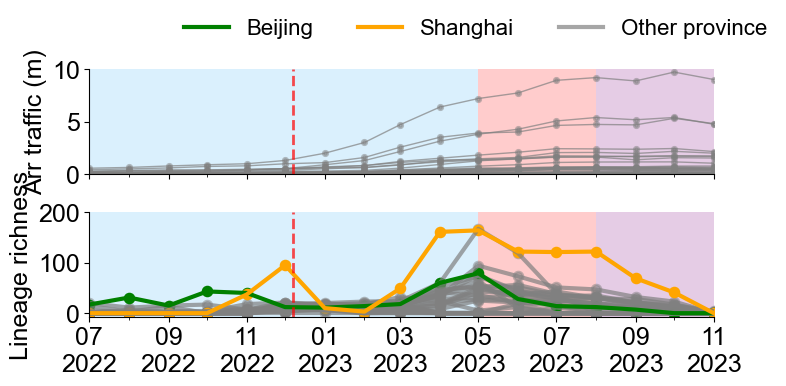

In [5]:
dominant_Omicron_sublineages = [ 'BA.5','BF.7', 'DY','XBB','EG.5','HK']
prov_lst = ['Anhui', 'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong', 'Guangxi', 'Guizhou', 
            'Hainan', 'Hebei', 'Heilongjiang', 'Henan', 'Hubei', 'Hunan', 'Jiangsu', 'Jiangxi', 'Jilin', 
            'Liaoning', 'Neimenggu', 'Ningxia', 'Qinghai', 'Shaanxi', 'Shandong', 'Shanghai', 'Shanxi', 'Sichuan', 
            'Tianjin', 'Xinjiang', 'Xizang', 'Yunnan', 'Zhejiang']
color_dct = {i:'grey' for i in prov_lst}
color_dct['Beijing']='green'
color_dct['Shanghai'] = 'orange'
df_flight = pd.read_csv('Province_air_travel_inflow.csv')
fontsize=18
plt.rcParams['pdf.fonttype'] = 42
fig, ax = plt.subplots(2,1,figsize = (8,4),sharex='all')
ax_array = ax.flatten()
ax1 = ax_array[0]
ax2 = ax_array[1]
date_lst =  [datetime.datetime.strptime(str(i), '%Y%m') for i in df_flight.columns]  
for prov in df_flight.index:
    v_lst = df_flight.loc[prov].tolist()
    if prov=='Beijing':
        ax1.plot(date_lst,v_lst,color = color_dct['Beijing'],linewidth = 3,alpha = 1,zorder = 2,label ='Beijing')
        ax1.scatter(date_lst,v_lst,ec = color_dct['Beijing'],c = color_dct['Beijing'],alpha = 1,s=40,linewidths = 2)
    elif prov=='Shanghai':
        ax1.plot(date_lst,v_lst,color = color_dct['Shanghai'],linewidth =3,alpha = 1,zorder = 2,label ='Shanghai')
        ax1.scatter(date_lst,v_lst,ec = color_dct['Shanghai'], c = color_dct['Shanghai'],alpha = 1,s=40,linewidths = 2)
    else:
        ax1.plot(date_lst,v_lst,color = 'grey',linewidth =1,alpha = 0.7,zorder = 2,label= 'Other province')
        ax1.scatter(date_lst,v_lst,ec = 'grey',c = 'grey',alpha = 0.5,s = 10,linewidths = 2)    
df = pd.read_csv('../data/cn_meta.csv')
df['year_month'] = ['%s-%s' %
                    (i.split('-')[0], i.split('-')[1]) for i in df['Collection date']]
entropy_dct = defaultdict(dict)
prov_lst = ['Anhui', 'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong', 'Guangxi', 'Guizhou',
            'Hainan', 'Hebei', 'Heilongjiang', 'Henan', 'Hubei', 'Hunan', 'Jiangsu',
            'Jiangxi', 'Jilin', 'Liaoning', 'Neimenggu', 'Ningxia', 'Qinghai',
            'Shaanxi', 'Shandong', 'Shanghai', 'Shanxi', 'Sichuan', 'Tianjin', 'Xinjiang', 'Xizang', 'Yunnan', 'Zhejiang']

df = df[(df['year_month'] >='2022-07') & (df['year_month'] <='2023-11-31')]                
t_lst = sorted(df.year_month.unique())
for t in t_lst:
    for prov in prov_lst:
        entropy_dct[t][prov] = 0
for t in sorted(df.year_month.unique()):
    dfi = df.query('year_month==@t')
    for x, y in dfi['Pango lineage'].groupby([dfi['Province']]):
        richness_i = len(set(y))
        entropy_dct[t][x[0]] =  richness_i
entropy_prov_dct = defaultdict(list)
for prov in prov_lst:
    for t in t_lst:
        entropy_prov_dct[prov].append(entropy_dct[t][prov])
Beijing_lst = entropy_prov_dct['Beijing']
Shanghai_lst = entropy_prov_dct['Shanghai']
entropy_prov_dct.pop('Beijing')
entropy_prov_dct.pop('Shanghai')
date_lst =  [datetime.datetime.strptime(i, '%Y-%m') for i in sorted(df.year_month.unique())] 
for prov,richness_lst in entropy_prov_dct.items():
    ax2.plot(date_lst,richness_lst,color = 'grey',linewidth =3,alpha = 0.7,zorder = 2,label= 'Other province')
    ax2.scatter(date_lst,richness_lst,ec = 'grey',c = 'grey',alpha = 0.5,s = 40,linewidths = 2)  
ax2.plot(date_lst,Beijing_lst,color = color_dct['Beijing'],linewidth = 3,alpha = 1,zorder = 2,label ='Beijing')
ax2.plot(date_lst,Shanghai_lst,color = color_dct['Shanghai'],linewidth =3,alpha = 1,zorder = 2,label ='Shanghai')
ax2.scatter(date_lst,Beijing_lst,ec = color_dct['Beijing'],c = 'green',alpha = 1,s=40,linewidths = 2)
ax2.scatter(date_lst,Shanghai_lst,ec = color_dct['Shanghai'], c = 'orange',alpha = 1,s=40,linewidths = 2)
for axi in [ax1,ax2]:
    axi = StandardPlot(axi,fontsize = fontsize,right=False,top = False,grid = False,ticks = True)
    monthlocator = MonthLocator()
    axi.xaxis.set_minor_locator(monthlocator)
    axi.xaxis.set_major_formatter(DateFormatter('%m\n%Y')) 
    x_start_str,x_end_str = '2022-07', '2023-11'  
    format_str = '%Y-%m'  
    x_start_date= datetime.datetime.strptime(x_start_str, format_str)  
    x_end_date= datetime.datetime.strptime(x_end_str, format_str)  
    axi.set_xlim(x_start_date, x_end_date)
    t1 = datetime.datetime.strptime('2022-07-01', '%Y-%m-%d')
    t2 = datetime.datetime.strptime('2023-05-01', '%Y-%m-%d')
    t3 = datetime.datetime.strptime('2023-08-01', '%Y-%m-%d')
    t4 = datetime.datetime.strptime('2023-11-01', '%Y-%m-%d')
    t_lift = datetime.datetime.strptime('2022-12-07', '%Y-%m-%d')
    axi.axvspan(t1, t2, facecolor='#87CEFA',alpha = 0.3,zorder = 0)
    axi.axvspan(t2, t3, facecolor='red',alpha = 0.2,zorder =0)
    axi.axvspan(t3, t4, facecolor='purple',alpha = 0.2,zorder = 0)
    axi.axvline(x=t_lift,linewidth = 2,color = 'red',linestyle='--',alpha = 0.7)
    handles, labels = axi.get_legend_handles_labels()
ax1.legend([handles[labels.index(i)] for i in  ['Beijing','Shanghai','Other province']], ['Beijing','Shanghai','Other province'], 
           bbox_to_anchor = (0.12,1.1),
           # loc = 'upper center', 
           ncols = 3,
           prop={'family': 'arial', 'size': fontsize-2},frameon=False)
ax1.set_ylabel('Arr traffic (m)',fontdict={'family':'arial','fontsize':fontsize})
ax1.set_ylim([0,10])
ax2.set_yticks([0,100,200])
ax2.set_ylabel('Lineage richness',fontdict={'family':'arial','fontsize':fontsize})
plt.tight_layout()